In [11]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.utils.data as Data
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from train_evaluate import Trainer

%run train_evaluate.py

In [12]:
# 手写数字训练数据集
mnist = np.load("../../../Other/datasets/NumPy/mnist.npz")
X_train, y_train, X_val, y_val = torch.unsqueeze(torch.tensor(mnist['x_train']), 1).to(dtype=torch.float32), \
                                 torch.tensor(mnist['y_train']).to(dtype=torch.long), \
                                 torch.unsqueeze(torch.tensor(mnist['x_test']), 1).to(dtype=torch.float32), \
                                 torch.tensor(mnist['y_test']).to(dtype=torch.long)
X_train, X_val = X_train / 255.0, X_val / 255.0

In [13]:
batch_size = 200
train_data = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(dataset=train_data,
                               batch_size=batch_size,
                               shuffle=True)
val_data = Data.TensorDataset(X_val, y_val)
val_loader = Data.DataLoader(dataset=val_data, batch_size=batch_size)

test_data = Data.TensorDataset(X_val)
test_loader = Data.DataLoader(dataset=test_data, batch_size=batch_size)

In [14]:
print(len(train_loader))
print(len(train_loader.dataset))

300
60000


In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.featrues = nn.Sequential(  # 内部实现了forward函数;各模块顺序执行
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10分类问题
        )

    def forward(self, x):
        x = self.featrues(x)
        x = x.reshape(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [16]:
learning_rate = 0.001
criteon = nn.CrossEntropyLoss()  # 定义损失函数为交叉熵
net = LeNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet = net.to(device)  # 模型设备切换必须在优化器定义前执行
optimizer = optim.AdamW(net.parameters(), lr=learning_rate)

In [17]:
t_and_v = Trainer(model=lenet, optimizer=optimizer, criterion=criteon, epochs=10)

In [18]:
def compute_metrics_acc(predict_all, y_true):
    predict = predict_all.argmax(-1)
    label = y_true
    acc = accuracy_score(label, predict)
    return {"acc": acc}

In [19]:
metric_result = t_and_v.train(train_loader=train_loader, valid_loader=val_loader, compute_metrics=compute_metrics_acc)
print(metric_result)  # 每一轮验证数据集的损失值

Train Epoch: 0  [0    /60000 (0  %)]	Loss: 2.297695	acc: 0.120000
Train Epoch: 0  [4000 /60000 (7  %)]	Loss: 2.121043	acc: 0.645000
Train Epoch: 0  [8000 /60000 (13 %)]	Loss: 1.094205	acc: 0.675000
Train Epoch: 0  [12000/60000 (20 %)]	Loss: 0.541826	acc: 0.785000
Train Epoch: 0  [16000/60000 (27 %)]	Loss: 0.596948	acc: 0.790000
Train Epoch: 0  [20000/60000 (33 %)]	Loss: 0.619564	acc: 0.810000
Train Epoch: 0  [24000/60000 (40 %)]	Loss: 0.582427	acc: 0.825000
Train Epoch: 0  [28000/60000 (47 %)]	Loss: 0.220300	acc: 0.940000
Train Epoch: 0  [32000/60000 (53 %)]	Loss: 0.428458	acc: 0.865000
Train Epoch: 0  [36000/60000 (60 %)]	Loss: 0.228408	acc: 0.940000
Train Epoch: 0  [40000/60000 (67 %)]	Loss: 0.278002	acc: 0.935000
Train Epoch: 0  [44000/60000 (73 %)]	Loss: 0.219371	acc: 0.935000
Train Epoch: 0  [48000/60000 (80 %)]	Loss: 0.185753	acc: 0.950000
Train Epoch: 0  [52000/60000 (87 %)]	Loss: 0.263152	acc: 0.910000
Train Epoch: 0  [56000/60000 (93 %)]	Loss: 0.171572	acc: 0.955000
Train Epoc

In [20]:
metric_result_df = pd.DataFrame(metric_result)
metric_result_df.index.name = 'epoch'
metric_result_df

,Training loss,Training acc,Validation loss,Validation acc
epoch,,,,
0,0.197398,0.938133,0.181048,0.9447
1,0.115512,0.964167,0.101943,0.9680
2,0.077826,0.975933,0.072656,0.9773
3,0.061615,0.981050,0.058915,0.9808
4,0.051403,0.984633,0.050432,0.9834
5,0.046151,0.986083,0.048958,0.9835
6,0.038902,0.988233,0.045928,0.9854
7,0.039681,0.987550,0.046298,0.9845
8,0.036213,0.988450,0.044460,0.9861


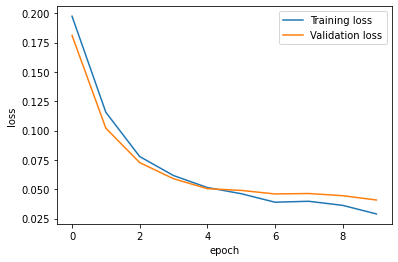

In [26]:
plt.plot(metric_result['Training loss'], label='Training loss')
plt.plot(metric_result['Validation loss'], label='Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

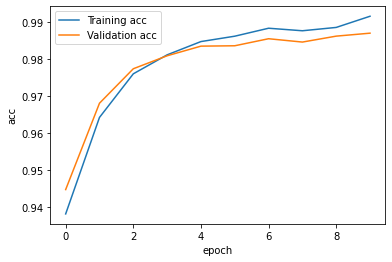

In [27]:
plt.plot(metric_result['Training acc'], label='Training acc')
plt.plot(metric_result['Validation acc'], label='Validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [23]:
pre_result = t_and_v.predict(test_loader, status='Test')
print(pre_result)
print(pre_result.shape)

tensor([[ -3.3228,  -0.7422,   1.1993,  ...,  14.3720,  -3.8392,  -0.5684],
        [  2.7593,   4.2663,  18.0228,  ...,  -6.7618,   0.5068, -11.2879],
        [ -2.9025,   9.2152,  -0.1106,  ...,   0.4085,  -0.9986,  -5.0396],
        ...,
        [ -8.1527,  -2.8910,  -5.4181,  ...,  -1.7568,  -0.5016,  -2.2881],
        [ -4.4256, -10.7319,  -9.7188,  ...,  -7.7688,   4.5311,  -3.7905],
        [ -0.1946, -10.1519,   0.1435,  ..., -13.4627,   1.2175,  -4.9107]],
       device='cuda:0')
torch.Size([10000, 10])
